# Purpose: Solve the electronic structure problem with quantum computers + classic interpolation

## Step 1: create a quantum circuit that can estimate the eigenvalue of any Hermitian matrix

In [13]:
import sys
sys.path.append('..\\')
import scipy
import numpy as np
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2

Given an arbitray Hermintian matrix $H_j$ let us construct a quantum circuit that uses the gate representation of the 
unitary matrix $e^{iH_j}$ to estimate the eigenvalues of $H_j$.

We take advantage of the "phase kickback" phenomenon where the phase of the control qubit is affected by the target qubit.
 
Thus, in addition to the circuit itself, we need to prepare a state $\psi$ which must be an eigenstate of $H_j$.

In [23]:

# Generate a random 2x2 Hermitian matrix with real eigenvalues.

def generate_random_hermitian():
    # 'a' and 'c' are the diagonal elements and must be real.
    a = np.random.rand()
    c = np.random.rand()
    # 'b' is the off-diagonal element and can be complex.
    b = np.random.rand()

    # Construct the 2x2 Hermitian matrix
    # The off-diagonal elements are conjugates of each other.
    hermitian_matrix = np.array([[a, b], [np.conjugate(b), c]])

    assert(scipy.linalg.ishermitian(hermitian_matrix))
    print(f'Hermitian matrix: \n{hermitian_matrix}')
    return hermitian_matrix


Hermitian matrix: 
[[0.35678053 0.12398675]
 [0.12398675 0.67692479]]
current number of evaluations: 1
{'0': 1}
1.0
estimation: 0.0 
 exact answer: 0.3143784615259618
current number of evaluations: 11
{'0': 11}
1.0
estimation: 0.0 
 exact answer: 0.3143784615259618
current number of evaluations: 21


C:\Users\u1037737\AppData\Local\Temp\ipykernel_50572\1436623017.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"estimation: {estimated_eigenvalue} \n exact answer: {float(min(exact_eigenvalue))}")


{'0': 21}
1.0
estimation: 0.0 
 exact answer: 0.3143784615259618
current number of evaluations: 31
{'0': 29, '1': 2}
0.9354838709677419
estimation: 0.5136278348416145 
 exact answer: 0.3143784615259618
current number of evaluations: 41
{'0': 39, '1': 2}
0.9512195121951219
estimation: 0.4453985739914743 
 exact answer: 0.3143784615259618
current number of evaluations: 51
{'0': 51}
1.0
estimation: 0.0 
 exact answer: 0.3143784615259618
current number of evaluations: 61
{'0': 61}
1.0
estimation: 0.0 
 exact answer: 0.3143784615259618
current number of evaluations: 71
{'0': 70, '1': 1}
0.9859154929577465
estimation: 0.23791706740640342 
 exact answer: 0.3143784615259618
current number of evaluations: 81
{'0': 79, '1': 2}
0.9753086419753086
estimation: 0.315577556104761 
 exact answer: 0.3143784615259618
current number of evaluations: 91
{'0': 90, '1': 1}
0.989010989010989
estimation: 0.2100428658155569 
 exact answer: 0.3143784615259618
current number of evaluations: 101
{'0': 98, '1': 3}


C:\Users\u1037737\AppData\Local\Temp\ipykernel_50572\1436623017.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  all_experiments.append((iterations, estimations, float(min(exact_eigenvalue))))


{'0': 44, '1': 7}
0.8627450980392157
estimation: 0.7590499460279201 
 exact answer: 0.6194727892632848
current number of evaluations: 61
{'0': 54, '1': 7}
0.8852459016393442
estimation: 0.6911840177000432 
 exact answer: 0.6194727892632848
current number of evaluations: 71
{'1': 9, '0': 62}
0.8732394366197183
estimation: 0.7280417454281082 
 exact answer: 0.6194727892632848
current number of evaluations: 81
{'1': 7, '0': 74}
0.9135802469135802
estimation: 0.5967604047894476 
 exact answer: 0.6194727892632848
current number of evaluations: 91
{'0': 80, '1': 11}
0.8791208791208791
estimation: 0.7101842569092697 
 exact answer: 0.6194727892632848
current number of evaluations: 101
{'0': 90, '1': 11}
0.8910891089108911
estimation: 0.6726421113701248 
 exact answer: 0.6194727892632848
current number of evaluations: 111
{'0': 101, '1': 10}
0.9099099099099099
estimation: 0.609700037331727 
 exact answer: 0.6194727892632848
current number of evaluations: 121
{'0': 113, '1': 8}
0.93388429752066

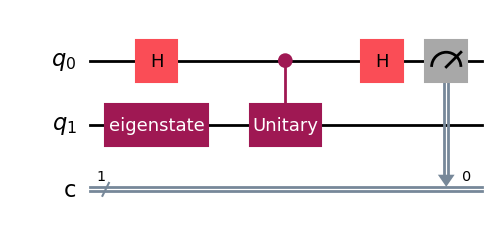

In [53]:
from qiskit_aer import Aer

num_random_matrices = 6
max_iterations = 10000
selected_backend = Aer.get_backend('qasm_simulator')

all_experiments = []

for i in range(num_random_matrices):

    test_hermitian = generate_random_hermitian()

    # for testing purposes, we also analytically calculate the eigenvalues
    exact_eigenvalue, eigenvectors= scipy.linalg.eig(test_hermitian)

    U = scipy.linalg.expm(1j * test_hermitian) 

    # pick eigenstate that corresponds to smallest eigenvalue
    eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)]
    iterations = []
    estimations = []

    for j in range(1, max_iterations, 10):
        print(f'current number of evaluations: {j}')
        p_0, qc = iterative_phase_estimation_v2(U=U, eigenstate=eigenstate, num_evals=j, backend=selected_backend, num_qubits=1)
        print(p_0)
        estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) # 
        iterations.append(j)
        estimations.append(estimated_eigenvalue)
        print(f"estimation: {estimated_eigenvalue} \n exact answer: {float(min(exact_eigenvalue))}")
    
    all_experiments.append((iterations, estimations, float(min(exact_eigenvalue))))

qc.draw(output='mpl')


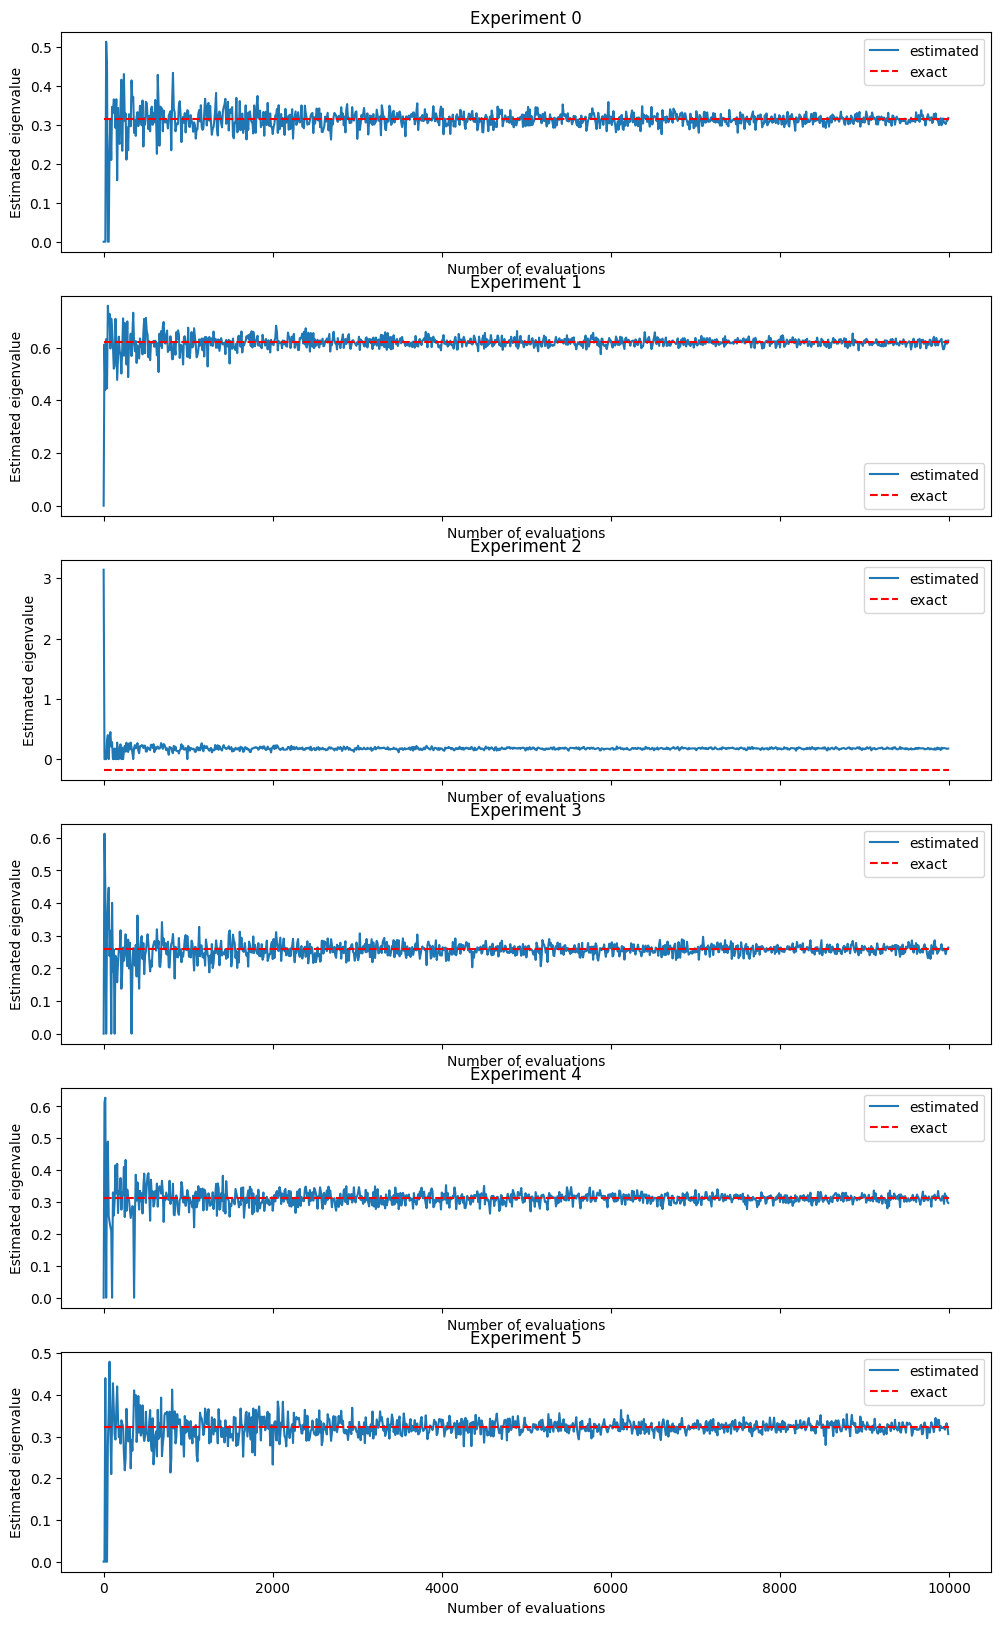

In [54]:
# create a subplot for every experiment
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=num_random_matrices, ncols=1, figsize=(12, 20), sharex=True, sharey=False)

for i, (iterations, estimations, exact) in enumerate(all_experiments):
    axs[i].plot(iterations, estimations, label='estimated')
    axs[i].hlines(exact, 0, max_iterations, colors='r', linestyles='dashed', label='exact')
    axs[i].set_title(f'Experiment {i}')
    axs[i].set_xlabel('Number of evaluations')
    axs[i].set_ylabel('Estimated eigenvalue')
    axs[i].legend()

plt.show()

